In [1]:
from tinyai import *

import pickle,gzip,math,os,time,shutil,random,logging,torch
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval import metrics

set_output()
toggle_mpl_cmap()

setting cmap: gray_r


In [2]:
from datasets import load_dataset

dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

import torchvision.transforms.functional as TF

xmean,xstd = 0.286, 0.353

@inplace
def transformi(b): b[x] = [TF.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[x]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=16, pin_memory=True)

In [3]:
betamin, betamax, nsteps = 0.0001, 0.01, 1000
beta = torch.linspace(betamin, betamax, nsteps)
alpha = 1 - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

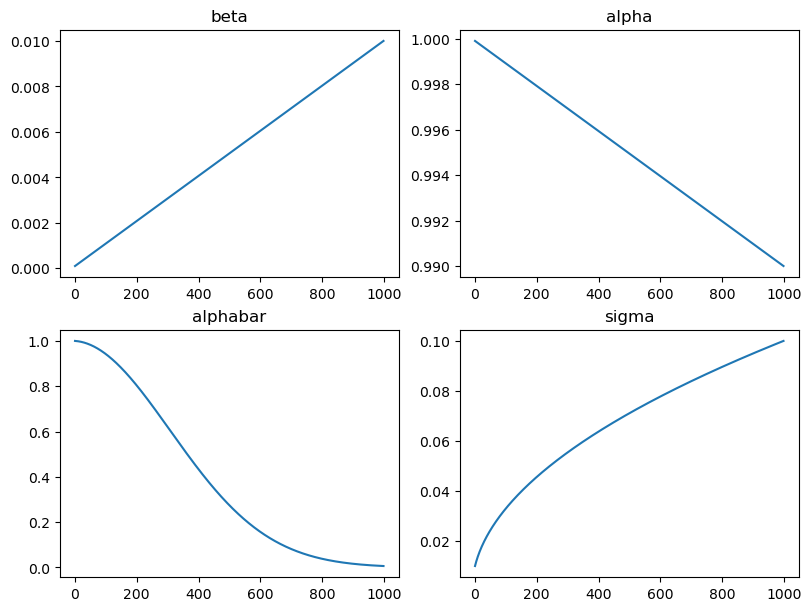

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
ax1.plot(beta); ax2.plot(alpha); ax3.plot(alphabar); ax4.plot(sigma)
ax1.set_title('beta'); ax2.set_title('alpha'); ax3.set_title('alphabar'); ax4.set_title('sigma')
plt.show()

Beta is the amount of variance added at each step, sigma is sqrt so is the **stdev** added at each step

Alpha bar is used with the cumprod, as if you add noise, then add more noise etc, the result is multipliying all the steps together up to that point

As t increases, the image gets more noisy. As the timesteps increase, this compounds until there is basically no information from the image.

x axis is t. When t is high, beta is higher (and alpha is lower)

- as t increases, alphabar drops and sigma increass

alpha is only from 1 - 0.98, this causes the cumprod to tend to 0 since numbers less than 0 * together will get smaller

- Epsilon: actual noise added -- also the target as the model predicts the noise

Example step

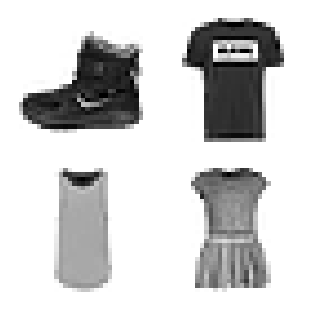

In [5]:
xb, _ = next(iter(dls.train))
show_images(xb[:4], imsize=1.5)

In [6]:
t = torch.randint(0, nsteps, (4,), dtype=torch.long)
print("t", t)
alphabar_t = alphabar[t]
print("alphabar_t", alphabar_t.shape)
print(f"alphabar_t: {alphabar_t}, sqrt(alphabar_t): {alphabar_t.sqrt()}")
scaled_xb = alphabar_t.reshape(-1, 1, 1, 1).sqrt() * xb
print("scaled_xb", scaled_xb.shape)


t tensor([345, 842, 679, 689, 276,  45, 362, 781,  33, 996, 569,  34,  80, 952, 311, 666, 858, 117,   7, 843,  84,  76, 839, 815, 288, 336,
        209, 301, 450, 717, 668, 384, 547, 986, 553, 902, 494, 863, 654, 737, 661, 103, 550, 266, 998, 844, 623, 787, 312, 511, 857,  14,
        539, 805, 657, 907, 738,  86, 530,  24, 143, 526, 238, 520, 657, 173, 757, 124, 698, 633, 246, 792, 778,   7, 501, 524, 147, 657,
        225, 747, 602, 604, 525, 857, 904, 698, 357, 498, 364, 778,  21, 130, 456, 951, 767, 480, 344, 587, 383, 714, 827, 976, 257, 787,
        818, 182, 685, 263, 343, 560, 367, 367, 566, 658, 300, 467, 956, 347, 102, 292, 930, 514, 132, 406, 826, 978, 906,  18, 949,  48,
        231, 252, 408, 683, 630, 667, 316, 528, 895, 205, 868, 291, 815, 543, 438, 320, 509, 828, 169, 979, 961, 167, 357, 375, 512,  90,
        806, 262, 182, 239, 821, 184, 788, 556, 884, 499, 502, 753, 964, 828, 425, 892, 976,  40, 141, 841,  70, 572,   6, 713,  87, 551,
        756, 442, 757, 595, 225,

In [7]:
(alphabar_t.reshape(-1, 1, 1, 1).sqrt() * xb).shape

torch.Size([512, 1, 32, 32])

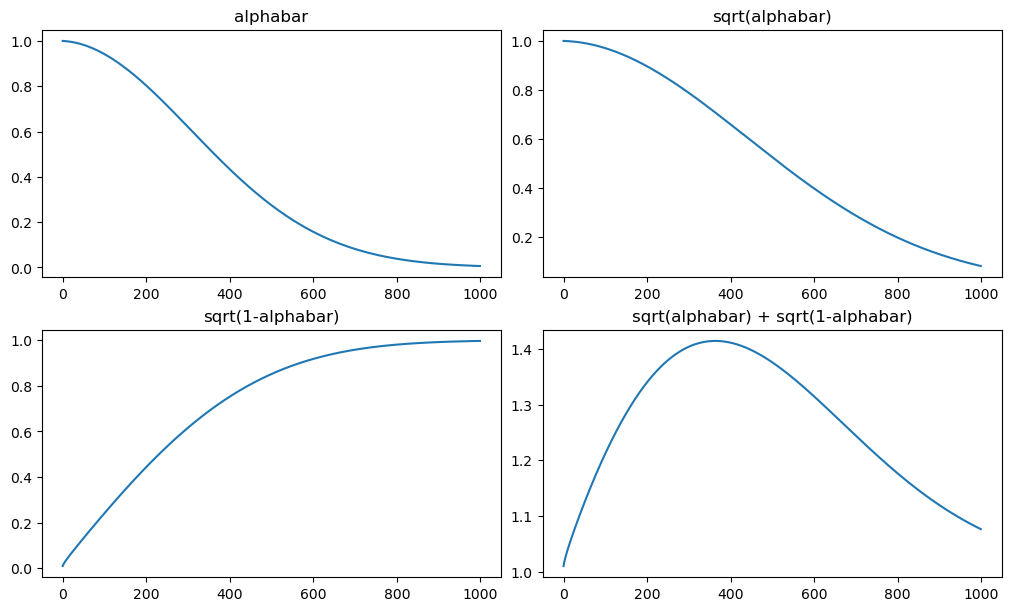

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
ax1.plot(alphabar); ax1.set_title('alphabar')
ax2.plot(alphabar.sqrt()); ax2.set_title('sqrt(alphabar)')
ax3.plot((1-alphabar).sqrt()); ax3.set_title('sqrt(1-alphabar)')
ax4.plot(alphabar.sqrt() + (1-alphabar).sqrt()); ax4.set_title('sqrt(alphabar) + sqrt(1-alphabar)')
plt.show()

This is what I was thinking -- when adding the original image bit (sqrt(alphabar)) with the random noise sqrt(1-alphabar) this won't add up to 1, and the intensity will increase??

What is the sqrt for? is it something like the variance???

In [9]:
from tqdm.notebook import tqdm

def noisify(x0, alphabar):
    device = x0.device
    bs = len(x0)
    t = torch.randint(0, nsteps, (bs,), dtype=torch.long)
    epsilon = torch.randn(x0.shape, device=device)
    # expanding each alphabar_t to a single item in the batch
    alphabar_t = alphabar[t][:, None, None, None]

    # weighted average of original image and noise
    xt = x0 * alphabar_t.sqrt() + (1 - alphabar_t).sqrt() * epsilon

    # noised image, timestep : epsilon (noise target)
    return xt, t.to(device), epsilon


@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, nsteps):
    device = next(model.parameters()).device
    xt = torch.randn(sz, device=device)
    preds = []

    for t in tqdm(list(reversed(range(nsteps)))):
        # contains a batch of items at time T. Starts at max (e.g. 1000) which is noise
        t_batch = torch.full((sz[0],), t, device=device, dtype=torch.long)

        if t == 0:  # final step, add no noise, use the image
            z = torch.zeros_like(xt, device=device)
            alphabar_t1 = torch.tensor(1)
        else:
            z = torch.randn_like(xt)
            alphabar_t1 = alphabar[t - 1]

        alpha_t = alpha[t]
        alphabar_t = alphabar[t]
        beta_t = 1 - alpha_t
        betabar_t = 1 - alphabar_t
        betabar_t1 = 1 - alphabar_t1
        sigma_t = sigma[t]

        noise_pred = model(xt, t_batch)  # previous image

        # attempting to completely remove the noise
        x0_hat = ( (xt - betabar_t.sqrt() * noise_pred) / alphabar_t.sqrt() ).clamp(-1, 1)

        # how much we keep of the estimated noise
        x0_coeff = alphabar_t1.sqrt() * beta_t / betabar_t

        # how much we keep of the previous image
        xt_ceoff = alpha_t.sqrt() * betabar_t1 / betabar_t

        added_noise = sigma_t * z

        # weighted average of the previous image and the estimated noise + added noise
        xt = x0_hat * x0_coeff + xt * xt_ceoff + added_noise

        # as we converge on t=0, our prediction of x0 will be more accurate,
        # so we weight x0_coeff and less xt_coeff

        preds.append(to_cpu(xt))
    return preds

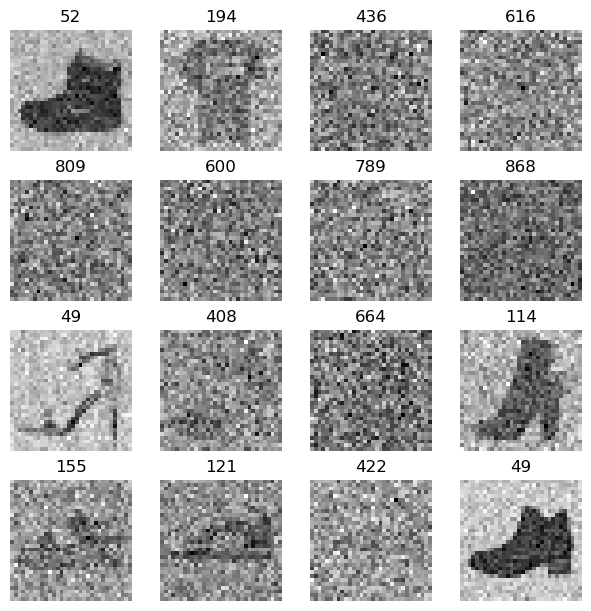

In [10]:
xt, t, epsilon = noisify(xb, alphabar)
show_images(xt[:16], imsize=1.5, titles=t.tolist())

In [11]:
# ignore y, default_collate is the default collation function


def collate_ddpm(b):
    return noisify(default_collate(b)[x], alphabar)

def dl_ddpm(ds, bs):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=16, pin_memory=True)

dls = DataLoaders(dl_ddpm(tds['train'], bs), dl_ddpm(tds['test'], bs))

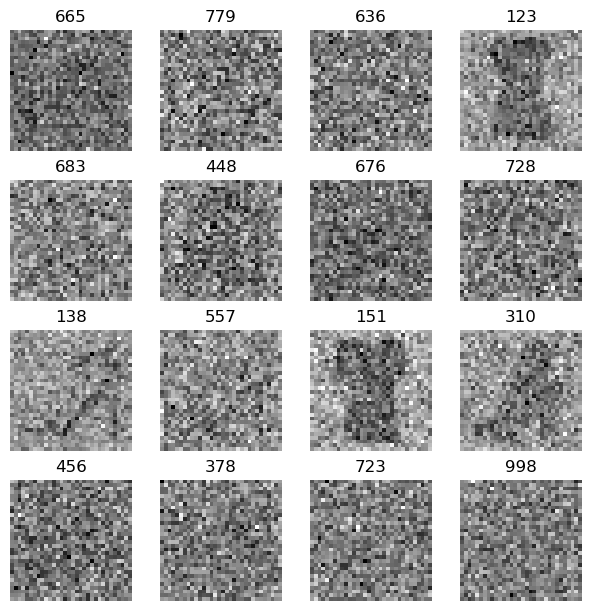

In [12]:
xb, t, e = next(iter(dls.train))
show_images(xb[:16], titles=t[:16].tolist(), imsize=1.5)

In [13]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, xb, t):
        return super().forward(xb, t).sample # type: ignore

def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
        for p in fc.L(o.downsamplers):
            init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

def get_model(nfs=(32,64,128,256)):
    return UNet(in_channels=1, out_channels=1, block_out_channels=nfs, norm_num_groups=8)

model = get_model()
init_ddpm(model)

learn = Trainer(model, dls, loss_func=F.mse_loss, cbs=PlotLossCB(plot_every=100))
learn.cbs[1] = AccelerateCB(n_inp=2)
# learn.summary()

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch: 0it [00:00, ?it/s]

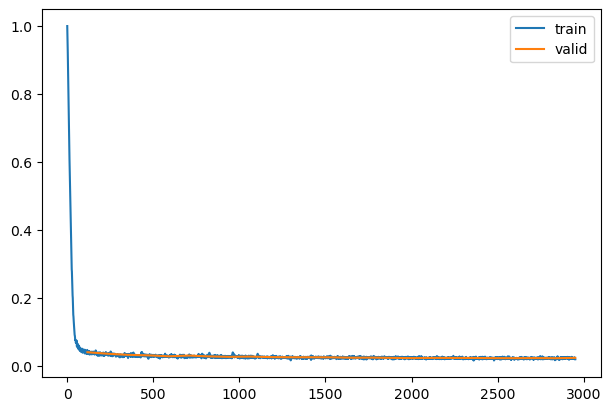

   epoch    train     loss
       0    train   0.1997
       0     eval   0.0392
       1    train   0.0349
       1     eval   0.0347
       2    train   0.0306
       2     eval   0.0314
       3    train   0.0297
       3     eval   0.0300
       4    train   0.0277
       4     eval   0.0272
       5    train   0.0271
       5     eval   0.0293
       6    train   0.0268
       6     eval   0.0269
       7    train   0.0257
       7     eval   0.0256
       8    train   0.0253
       8     eval   0.0263
       9    train   0.0248
       9     eval   0.0248
      10    train   0.0242
      10     eval   0.0244
      11    train   0.0232
      11     eval   0.0244
      12    train   0.0235
      12     eval   0.0241
      13    train   0.0231
      13     eval   0.0230
      14    train   0.0229
      14     eval   0.0232
      15    train   0.0229
      15     eval   0.0225
      16    train   0.0225
      16     eval   0.0218
      17    train   0.0221
      17     eval   0.0224
 

In [14]:
learn.fit_one_cycle(25, lr=1e-2)

In [15]:
torch.save(learn.model, "fashion_ddpm_25epochs_large.pkl")

  0%|          | 0/1000 [00:00<?, ?it/s]

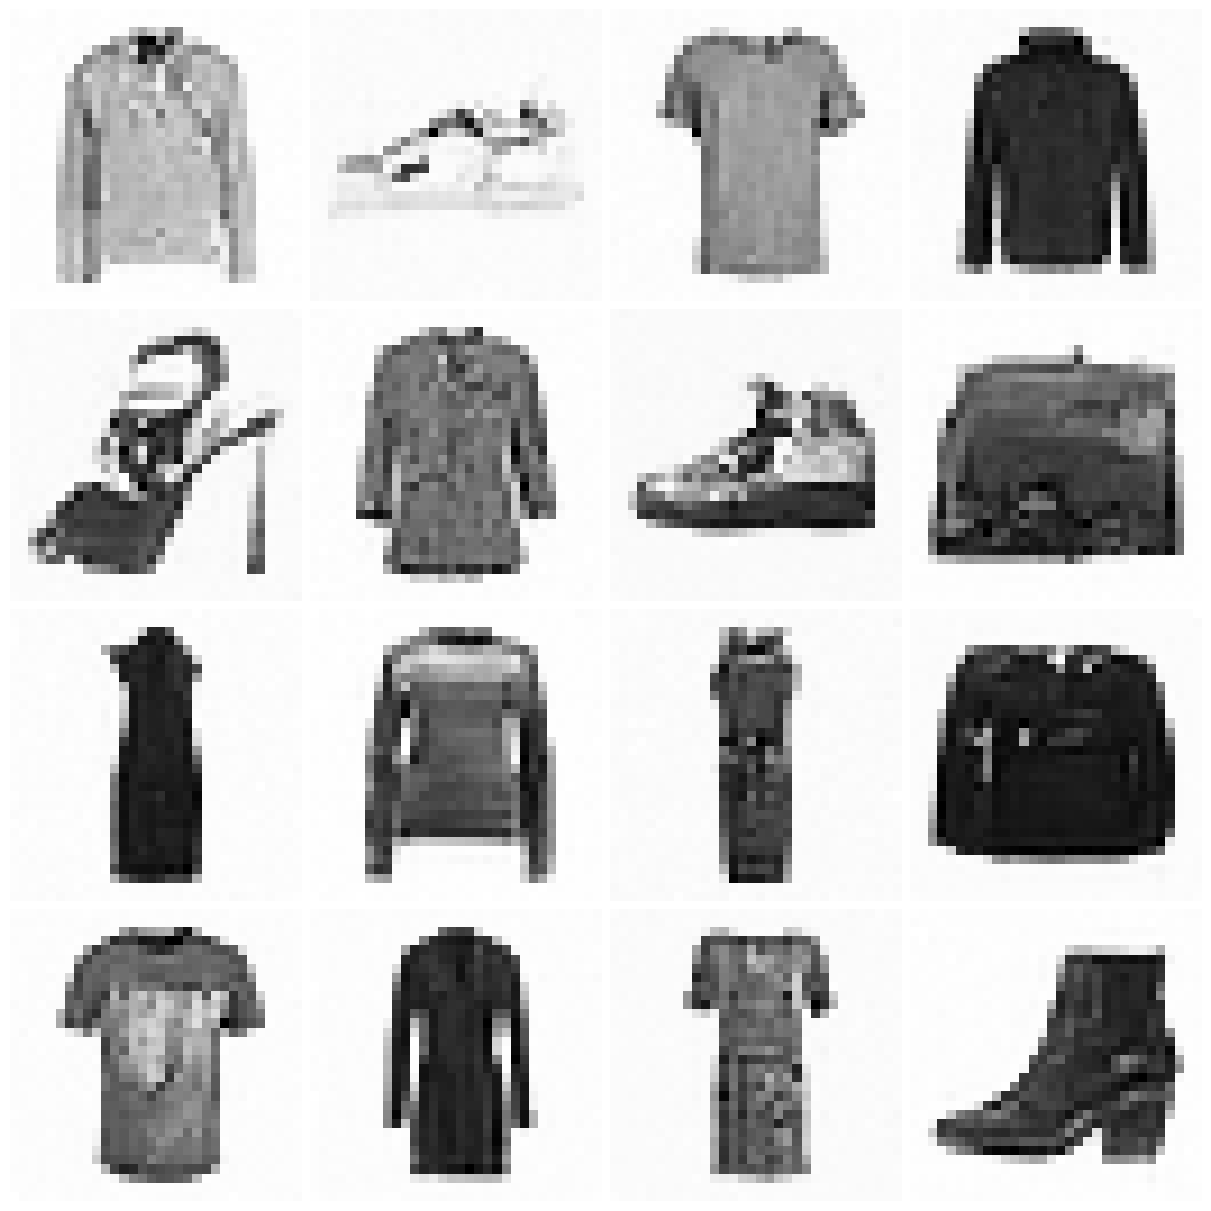

In [16]:
samples = sample(learn.model, (bs, 1, 32, 32), alpha, alphabar, sigma, 1000)
show_images(samples[-1][:16])